# The PolInSAR Course - January 23, 2023 
# Polarimetric SAR Interferometry (Pol-InSAR) 
# Part 1: The Pol-InSAR Coherence Region 

* DLR's F-SAR acquisition over Traunstein forest (Germany)
* Path: '/projects/s3-drive/user-data/polinsar/data/04-polinsar/'
* SLCs: 
    * Acquisition 1 : slc_15tmpsar0302_L { hh, hv, vv, vh } _t01.rat
    * Acquisition 2 : slc_coreg_15tmpsar0302_15tmpsar0303_L { hh, hv, vv, vh } _t01.rat
* Flat-earth: pha_flat_15tmpsar0302_15tmpsar0303_Lhh_t01.rat
* Vertical wavenumber (kz) : kz_2d_demc_15tmpsar0302_15tmpsar0303_t01.rat
* Lidar: Lida_r1503.rat

Objective:
- Calculate the dual-pol Pol-InSAR coherence region parameters, find the 2 extremes, and visualize them together with the phase difference. In addition, visualize the Pol-InSAR coherence region in one or more points.

Tips:
- work on the azimuth - range block [21500 - 4000, 21500 + 6000] - [2300, 4500] ;
- all the needed functions and a few pieces of script have been already implemented.

In [1]:
# import useful libraries, functions, and modules

import sys

sys.path.append('/projects/src/')

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend import Legend
from scipy.ndimage import filters

from ste_io import *

%matplotlib widget

**Auxiliary functions**

`calculate_covariance`: Calculates the covariance between two images while performing a multi-looking operation.

In [2]:
def calculate_covariance(im1, im2, looksr, looksa) : 
    
    # ... apply definition
    corr = filters.uniform_filter(np.real(im1*np.conj(im2)), [looksa,looksr]) + 1j* \
                filters.uniform_filter(np.imag(im1*np.conj(im2)), [looksa,looksr])
    
    # ... and back to main
    return corr

`make_pauli`: Generates an RGB Pauli image given the SLCs of the different polarimetric channels.

In [3]:
def make_pauli(slchh, slchv, slcvv, looksr, looksa) :
    
    # 1. Uses function calculate_covariance
    # 2. Convention (rows x columns): inputs are (az x rg), outputs are (rg x az) 
    #                                 for better plotting as #rg <#az
    
    # Calculate T11, T22 and T33
    T11 = calculate_covariance(slchh + slcvv, slchh + slcvv, looksr, looksa)
    T22 = calculate_covariance(slchh - slcvv, slchh - slcvv, looksr, looksa)
    T33 = calculate_covariance(2*slchv, 2*slchv, looksr, looksa)
    
    # make the pauli rgb (+ tranpose, clipping, normalization)
    dimaz = T11.shape[0]
    dimrg = T11.shape[1]
    rgb_pauli = np.zeros((dimrg, dimaz, 3), 'float32')
    rgb_pauli[:, :, 0] = np.transpose( np.clip(np.sqrt(np.abs(T22)), 0, 2.5*np.mean(np.sqrt(np.abs(T22)))) )    # red
    rgb_pauli[:, :, 1] = np.transpose( np.clip(np.sqrt(np.abs(T33)), 0, 2.5*np.mean(np.sqrt(np.abs(T33)))) )    # green
    rgb_pauli[:, :, 2] = np.transpose( np.clip(np.sqrt(np.abs(T11)), 0, 2.5*np.mean(np.sqrt(np.abs(T11)))) )    # blue
    rgb_pauli[:, :, 0] = rgb_pauli[:, :, 0] / np.max(rgb_pauli[:, :, 0])     # red
    rgb_pauli[:, :, 1] = rgb_pauli[:, :, 1] / np.max(rgb_pauli[:, :, 1])     # green
    rgb_pauli[:, :, 2] = rgb_pauli[:, :, 2] / np.max(rgb_pauli[:, :, 2])     # blue
    
    # ... and back to main
    return rgb_pauli

`matmul_2`: Mutiplies two matrices given the elements of each matrix separately.

In [4]:
def matmul_2(a11, a12, a21, a22, b11, b12, b21, b22) :
    
    # Implements the multiplication A.B of two 2 x 2 matrices A and B.
    # Inputs are the elements of matrices (row-wise). 
    # Outputs are the elements of the matrix product (row-wise).
    
    c11 = a11*b11 + a12*b21
    c12 = a11*b12 + a12*b22
    c21 = a21*b11 + a22*b21 
    c22 = a21*b12 + a22*b22
    
    # ... and back to main
    return c11, c12, c21, c22

`sqrt_inverse`: Calculates the square-root inverse of a 2x2 Hermitian matrix. **See Appendix 1.**

In [5]:
def sqrt_inverse(a11, a12, a22) :

    # Given a 2 x 2 Hermitian matrix A, calculates A**(-1/2) using eigendecomposition
    # Inputs are the upper-diagonal matrix elements (row-wise) - NumPy arrays.
    # Outputs are the elements of the sqrt inverse matrix.
    # Uses function matmul_2.
    
    # Calculate eigenvalues (l1, l2)
    sigma = 0.5 * (a11 + a22)
    D = a11*a22 - a12*np.conj(a12)
    delta = np.sqrt(sigma**2 - D)
    l1 = sigma + delta
    l2 = sigma - delta
    
    # Calculate eigenvector matrix elements (eigenvectors are the columns)
    norm_ = np.sqrt( a12*np.conj(a12) + ((a11-a22)/2 - delta)**2 )
    v11 = -a12 / norm_
    v21 = ((a11-a22)/2 - delta) / norm_
    v12 = ((a11-a22)/2 - delta) / norm_
    v22 = np.conj(a12) / norm_
    
    del norm_, delta, D, sigma
    
    # calculate sqrt inverse matrix elements
    zz = np.zeros(l1.shape, 'float32')
    aux11, aux12, aux21, aux22 = matmul_2(v11, v12, v21, v22, 1/np.sqrt(l1), zz, zz, 1/np.sqrt(l2))
    del l1, l2
    i11, i12, i21, i22 = matmul_2(aux11, aux12, aux21, aux22, np.conj(v11), np.conj(v21), np.conj(v12), np.conj(v22))
    del aux11, aux12, aux21, aux22
    
    # ... and back to main
    return i11, i12, i21, i22

`eigenvalvect_2`: Computes the eigenvalues and eigenvectors of a 2x2 matrix analytically. **See Appendix 2.**

In [6]:
def eigenvalvect_2(a11, a12, a21, a22) :
    
    # Calculates eigenvalues / eigenvectors of a generic complex-valued 2 x 2 matrix.
    # Inputs are the matrix elements (row-wise) - NumPy arrays
    # Outputs are the eigenvalues (l1, l2), and the eigenvector (E1, E2) elements - NumPy arrays
    #                                       E1 = [e11, e21] , U2 = [e12, e22]
    
    # eigenvalues 
    l1 = 0.5 * ((a11+a22) + np.sqrt( (a11-a22)**2 + 4*a12*a21 )) 
    l2 = 0.5 * ((a11+a22) - np.sqrt( (a11-a22)**2 + 4*a12*a21 ))
    
    # eigenvector 1
    e11 = -a12
    e21 = a11 - l1
    # normalize eigenvector 1
    norm_ = np.sqrt( np.abs(e11)**2 + np.abs(e21)**2 )
    e11 = e11 / norm_
    e21 = e21 / norm_
    # eigenvector 2
    e12 = a22 - l2
    e22 = -a21
    # normalize eigenvector 2
    norm_ = np.sqrt( np.abs(e12)**2 + np.abs(e22)**2 )
    e12 = e12 / norm_
    e22 = e22 / norm_
    
    del norm_
    
    # ... and back to main
    return l1, l2, e11, e21, e12, e22

`off_diagonal_2`: Calculates the off-diagonal form of a 2x2 matrix. **See Appendix 3.**

In [7]:
def off_diagonal_2(a11, a12, a21, a22, e11, e21, e12, e22) :

    # Calculates off-diagonal form a 2 x 2 matrix A given its eigenvalues in E
    # Inputs are the matrix elements (row-wise) - NumPy arrays
    #        and the eigenvector (E1, E2) elements - NumPy arrays
    #                                       E1 = [e11, e21] , U2 = [e12, e22]
    # Outputs are the off-diagonal elements: o12, o21
    
    # rotation angle theta
    theta = np.angle( np.conj(e11)*e12 + np.conj(e21)*e22  )
    
    # first column of the off-diagonalizing matrix (normalized)
    u11 = np.exp(1j*theta)*e11 + e12
    u21 = np.exp(1j*theta)*e21 + e22
    norm_ = np.sqrt( np.abs(u11)**2 + np.abs(u21)**2 )
    u11 = u11 / norm_
    u21 = u21 / norm_
    
    # second column of the off-diagonalizing matrix (normalized)
    u12 = np.exp(1j*theta)*e11 - e12
    u22 = np.exp(1j*theta)*e21 - e22
    norm_ = np.sqrt( np.abs(u12)**2 + np.abs(u22)**2 )
    u12 = u12 / norm_
    u22 = u22 / norm_
   
    del norm_
    
    # calculate off-diagonal elements
    o12 = a11 * ( np.conj(u11)*u12 - np.conj(u21)*u22 ) +\
          a12 * np.conj(u11) * u22 +\
          a21 * np.conj(u21) * u12
    o21 = a11 * ( np.conj(u12)*u11 - np.conj(u22)*u21 ) +\
          a12 * np.conj(u12) * u21 +\
          a21 * np.conj(u22) * u11
    
    # ... and back to main
    return o12, o21

`plot_coherence_region_P`: Reconstructs the **boundary** of the **Coherence Region**.

<div>
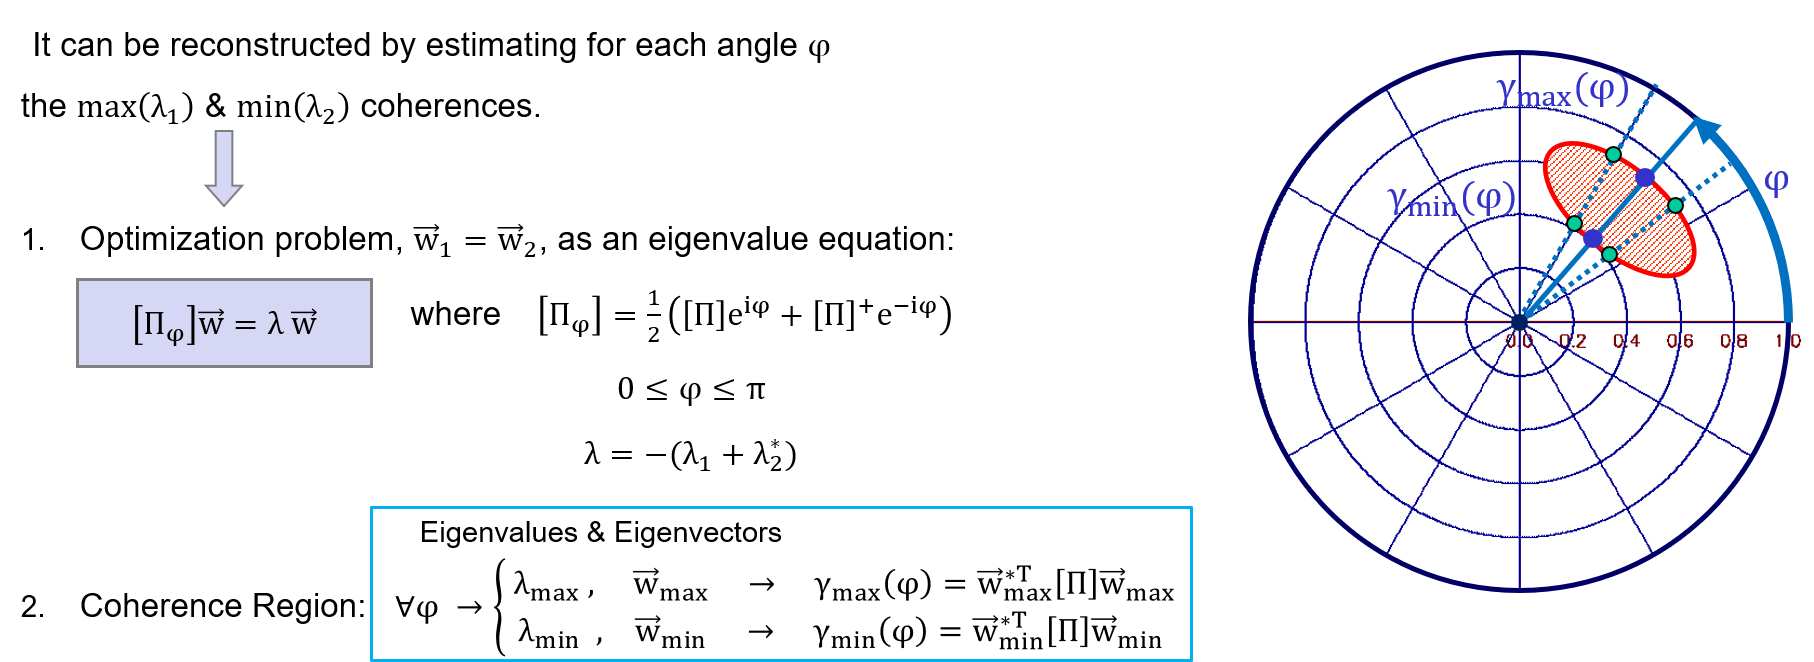
</div>

In [8]:
def plot_coherence_region_P(P11, P12, P21, P22, npoints=128, axes=None, color='r', **kwargs):
    
    # Pre-whitened coherency matrix
    M = np.asarray([[P11, P12], [P21, P22]])
    
    # Phasors
    theta = np.linspace(0, np.pi, npoints)
    
    # Optimizatin problem as an eigenvalue equation
    Wi,Vi = np.linalg.eigh(0.5*(M[None,...]*np.exp(1j*theta)[...,None,None] + np.conj(M.T)[None,...]*np.exp(-1j*theta)[...,None,None]))
    
    # Axes in polar coordinates
    if axes is None: ax = plt.subplot(111, projection='polar')
    else: ax = axes
    
    # Reconstruct the border of the Coherence Region
    indices = np.argsort(Wi, axis=-1)
    Z = np.einsum('...i,...ij,...j->...', np.conj(Vi[range(npoints),:,indices[:,-1]]), M, Vi[range(npoints),:,indices[:,-1]])
    Z2 = np.einsum('...i,...ij,...j->...', np.conj(Vi[range(npoints),:,indices[:,0]]), M, Vi[range(npoints),:,indices[:,0]])
    ax.plot(np.angle(Z), np.abs(Z), color, **kwargs)
    ax.plot(np.angle(Z2), np.abs(Z2), color, **kwargs)
    
    # ... and back to main
    return ax

`get_coh_reg_ellipse_params`: By using previous auxiliary functions, this function obtains the paramters of a **dual-pol Coherence Region**, i.e. an ellipse.

<div>
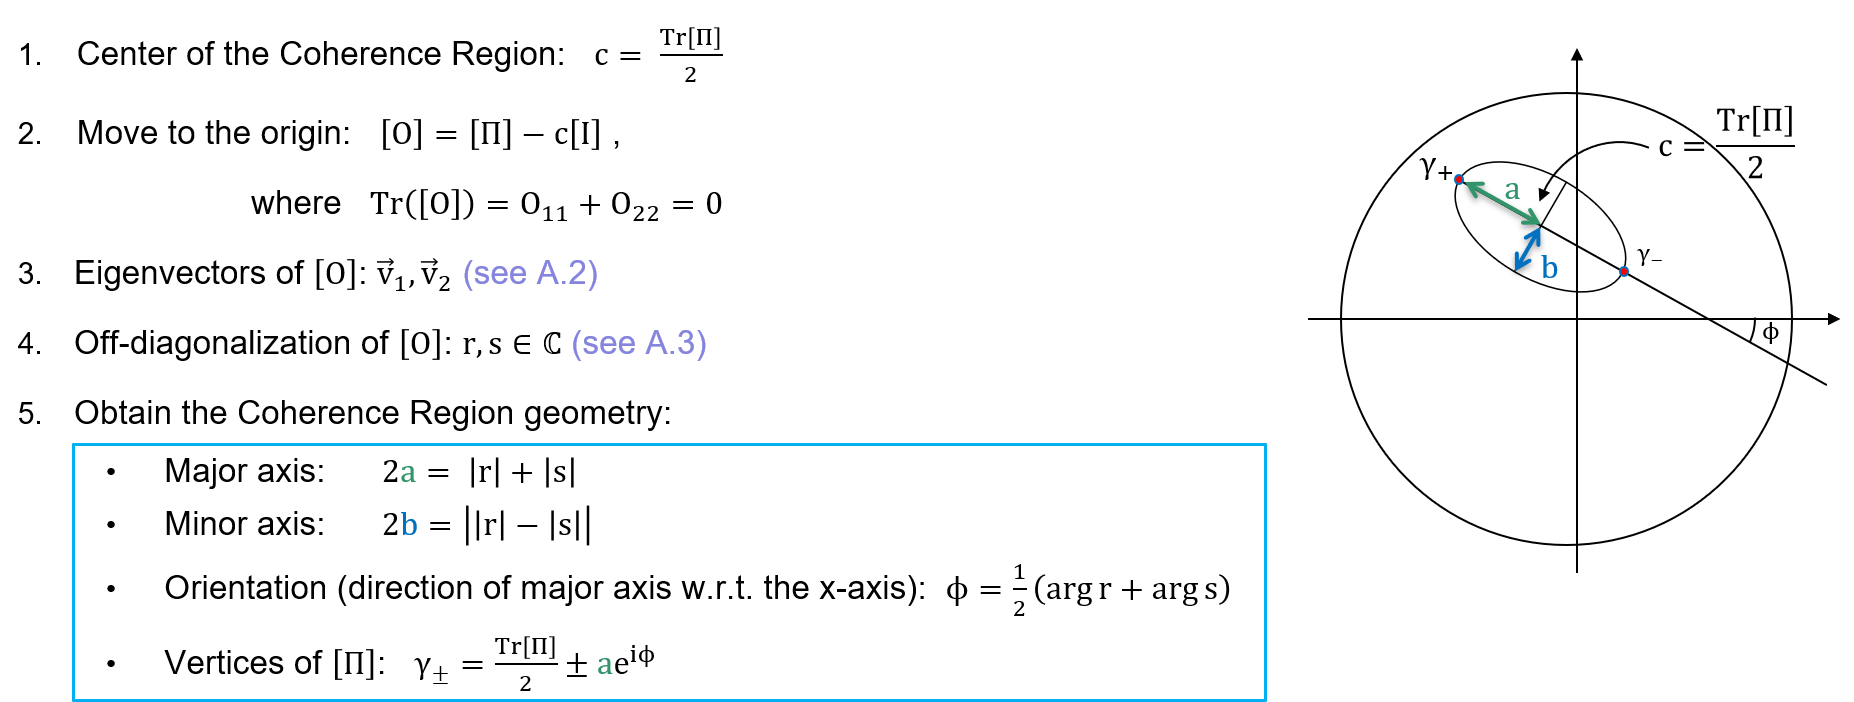
</div>

In [9]:
def get_coh_reg_ellipse_params(P11, P12, P21, P22, center):
    # --- eigenvectors
    l1, l2, e11, e21, e12, e22 = eigenvalvect_2(P11 - center, P12, P21, P22 - center)
    del l1, l2
    
    # --- off-diagonalization
    r, s = off_diagonal_2(P11 - center, P12, P21, P22 - center, e11, e21, e12, e22)

    # free memory
    del e11, e21, e12, e22

    # --- finally !! get Coherence Region geometry
    # ... major axis
    a2 = np.abs(r) + np.abs(s)
    # ... minor axis
    b2 = np.abs(np.abs(r) - np.abs(s))
    # ... rotation angle
    phi = 0.5 * (np.angle(r) + np.angle(s))
    
    # ... and back to main
    return a2, b2, phi

`optimize_coherence_and_phase`: By using previous auxiliary functions, this function performs a **Polar Decomposition** of a 2x2 matrix. As a result, it provides the **optimized extreme coherences**.

<div>
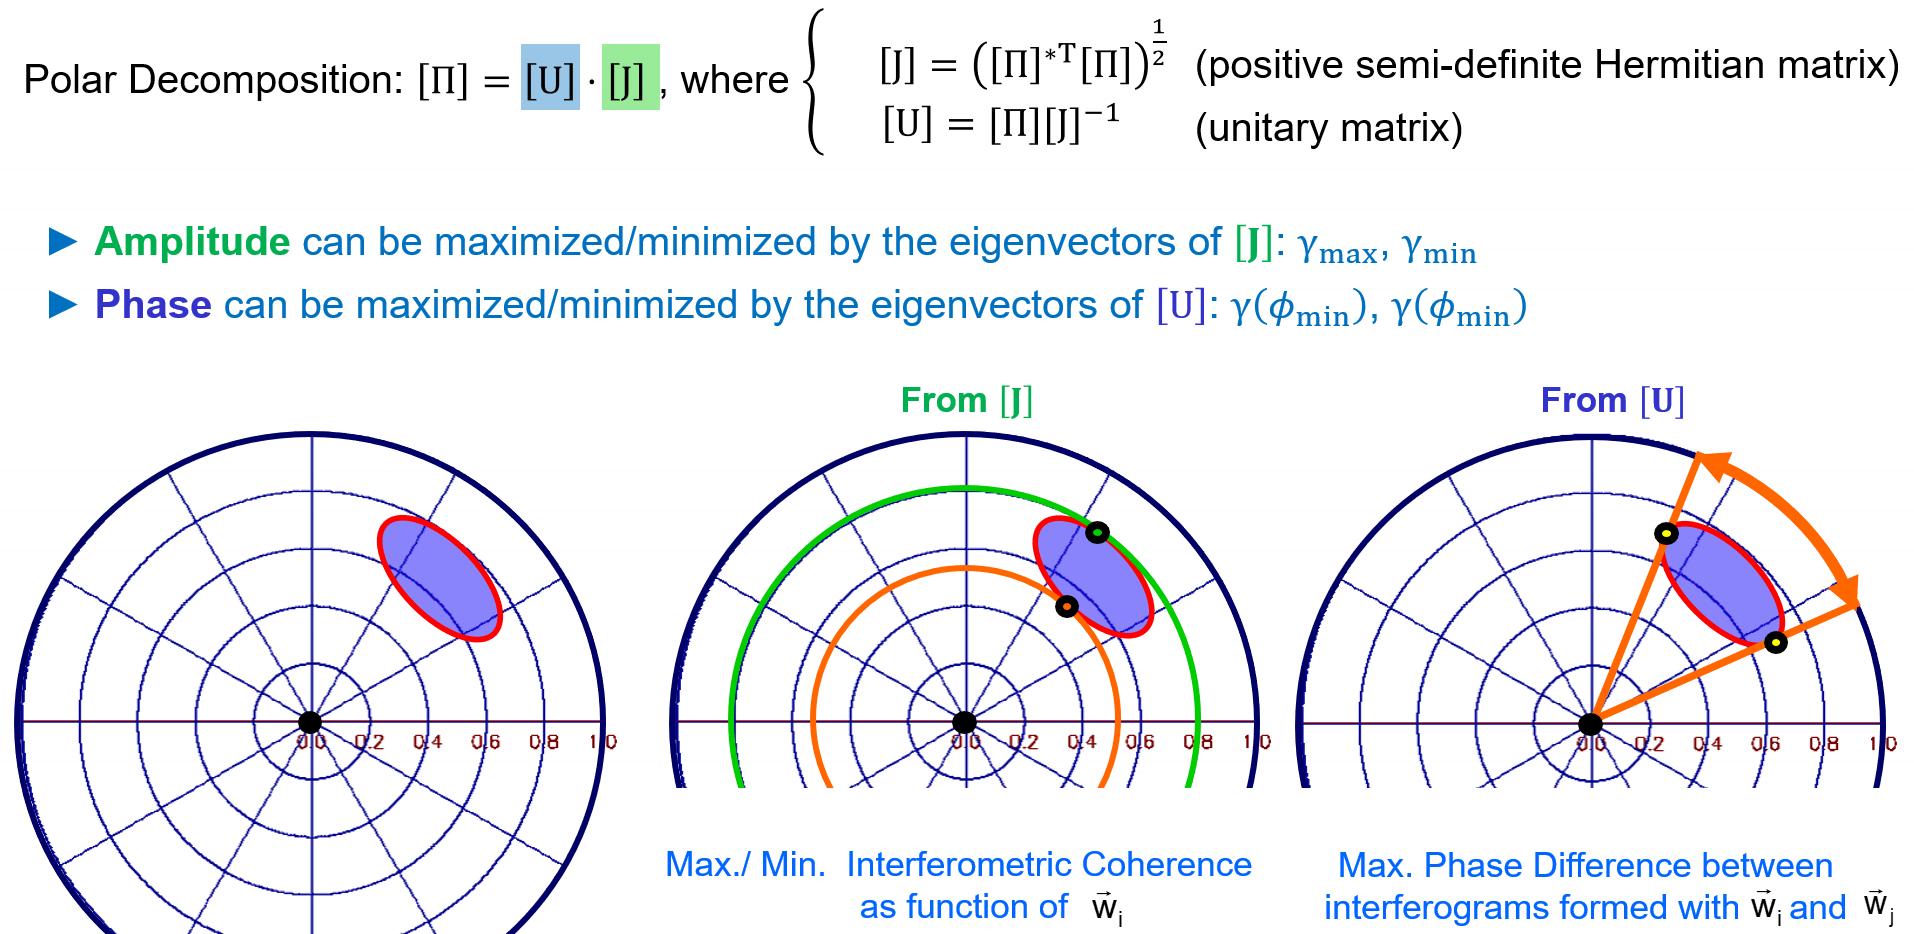
</div>

In [10]:
def optimize_coherence_and_phase(P11, P12, P21, P22):
    """
    Performs the Polar decomposition of the 2 by 2 matrix P with the given elements
    and estimates coherences with min max phase and absolute value.
    
    The polar decomposition of P is P = U * J.
    The max & min coherence is extracted from the eigenvectors of J and the
    max & min phase from the eigenvectors of U
    
    See: https://en.wikipedia.org/wiki/Polar_decomposition
    """
    
    # Calculate J^2 = P^(*T) * P
    J11, J12, J21, J22 = matmul_2(np.conj(P11), np.conj(P21), np.conj(P12), np.conj(P22), P11, P12, P21, P22)
    # Calculate eigenvalues and eigenvectors of J
    l1, l2, v11, v21, v12, v22 = eigenvalvect_2(J11, J12, J21, J22)
    del l1, l2
    
    # Calculate V^(*T) * P * V --> gamma max & min from there
    aux11, aux12, aux21, aux22 = matmul_2(np.conj(v11), np.conj(v21), np.conj(v12), np.conj(v22), P11, P12, P21, P22)
    gamma_max, gamma12, gamma21, gamma_min = matmul_2(aux11, aux12, aux21, aux22, v11, v12, v21, v22)
    del aux11, aux12, aux21, aux22, v11, v21, v12, v22
    del gamma12, gamma21
    
    # Compute U = P * J^(-1)
    Ji11, Ji1, Ji21, Ji22 = sqrt_inverse(J11, J12, J22)
    del J11, J12, J21, J22
    U11, U12, U21, U22 = matmul_2(P11, P12, P21, P22, Ji11, Ji1, Ji21, Ji22)
    del Ji11, Ji1, Ji21, Ji22
    
    # Calculate eigenvalues and eigenvectors of U
    l1, l2, w11, w21, w12, w22 = eigenvalvect_2(U11, U12, U21, U22)
    del l1, l2, U11, U12, U21, U22
    
    # Calculate W^(*T) * P * W --> gamma phamax & phamin from there
    aux11, aux12, aux21, aux22 = matmul_2(np.conj(w11), np.conj(w21), np.conj(w12), np.conj(w22), P11, P12, P21, P22)
    gamma_phamax, gamma12, gamma21, gamma_phamin = matmul_2(aux11, aux12, aux21, aux22, w11, w12, w21, w22)
    del aux11, aux12, aux21, aux22, w11, w21, w12, w22
    del gamma12, gamma21
    
    # Return optimum coherences
    return gamma_phamax, gamma_phamin, gamma_max, gamma_min

**Input parameters**

In [11]:
# --- Inputs

# path 2 acquisitions
path = '/projects/s3-drive/user-data/polinsar/data/04-polinsar/'
# path = 'data/04-polinsar/'

# input pixel spacing, in meters
spacrg = 0.59941552
spacaz = 0.19507939

# output range resolution, in meters
resrg = 5.
resaz = 5.

# image block for processing
minrg = 2300
maxrg = 4500
minaz = 21500 - 4000
maxaz = 21500 + 6000

In [12]:
# --- Calculate number of looks

looksr = int( resrg / spacrg )
if looksr % 2 == 0 : looksr = looksr +1
looksa = int( resaz / spacaz )
if looksa % 2 == 0 : looksa = looksa +1

print(looksa, looksr)

25 9


**Step 1: Open images, and visualize a Pauli**

In [13]:
# --- Acquisition 1

# --- Acquisition 2

In [14]:
# --- Pauli RGB

**Step 2 : Compensate flat-earth**

In [15]:
# --- Open flat-earth
fe = rrat(path + 'pha_flat_15tmpsar0302_15tmpsar0303_Lhh_t01.rat', block = [minaz, maxaz, minrg, maxrg])

# compensate

**Step 3 : Calculate the elements of T1, T2, and Omega matrices**

<div>
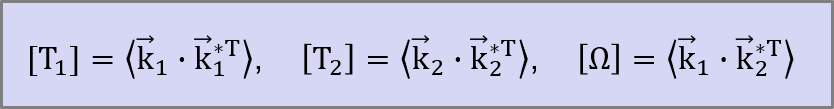
</div>


In [16]:
# --- Form polarization channels



# --- T1

# --- T2

# --- Omega

**Step 4 : Pre-whitening (normalization)**

<div>
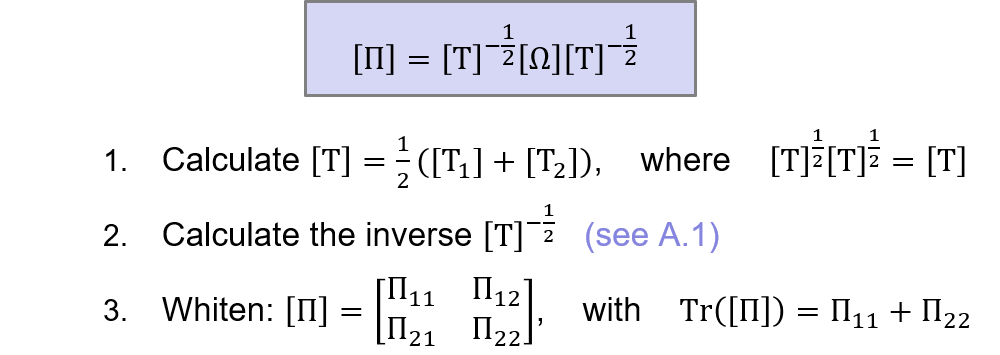
</div>

In [ ]:
# --- Pre-whitening

# calculate T
T11 = 0.5 * ( T1_11 + T2_11 )
T12 = 0.5 * ( T1_12 + T2_12 )
T22 = 0.5 * ( T1_22 + T2_22 )

# calculate the elements of T**(-1/2)
iT11, iT12, iT21, iT22 = sqrt_inverse(T11, T12, T22)

# free memory
del T11, T12, T22

# whiten ... two 2 x 2 multiplications ==> Matrix P
aux11, aux12, aux21, aux22 = matmul_2(iT11, iT12, iT21, iT22, Om_11, Om_12, Om_21, Om_22)
P11, P12, P21, P22 = matmul_2(aux11, aux12, aux21, aux22, iT11, iT12, iT21, iT22)

# free memory
del aux11, aux12, aux21, aux22
del iT11, iT12, iT21, iT22

**Step 5: Visualize the Coherence Region**

In [ ]:
# --- InSAR single-pol coherences

# free memory 
del T1_11, T1_12, T1_22, T2_11, T2_12, T2_22
del Om_11, Om_12, Om_21, Om_22

In [ ]:
# --- Plot coherence region for one pixel

**Step 6: Calculate the geometry of the Coherence Region**

<div>
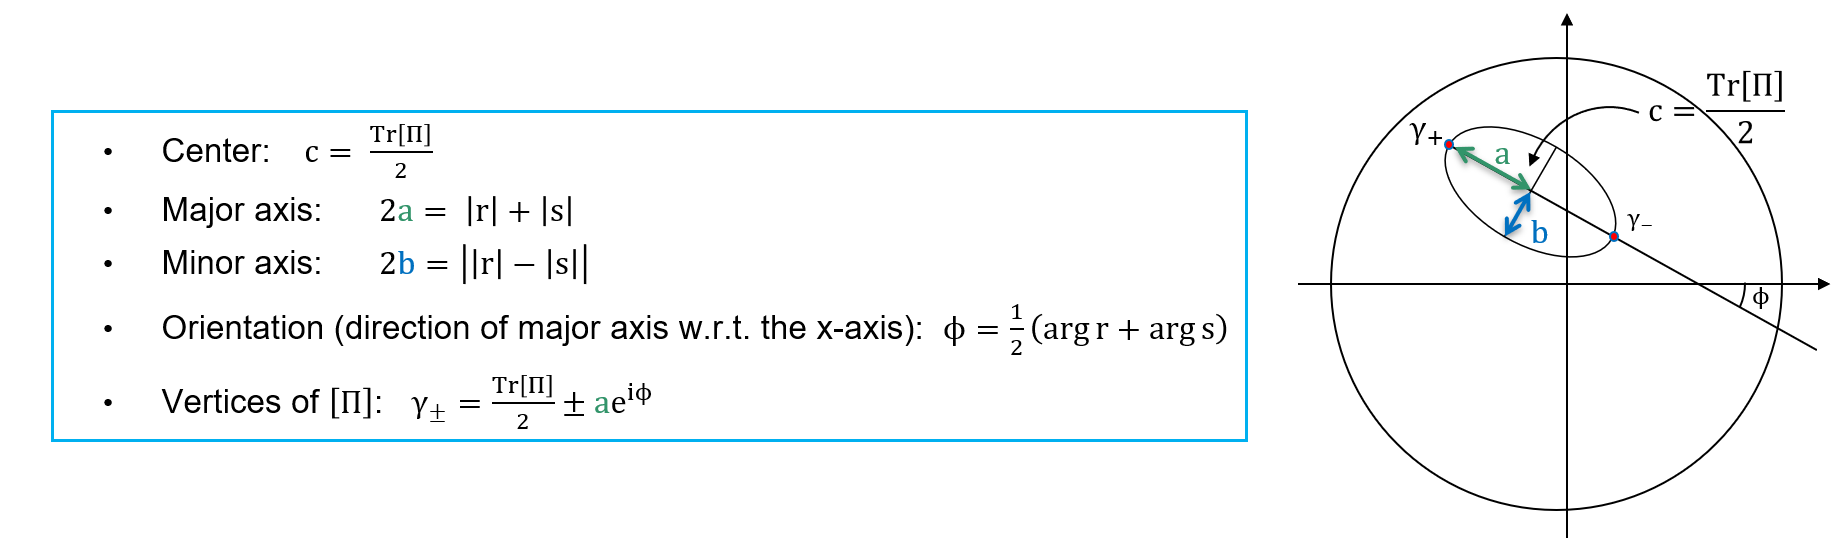
</div>

In [ ]:
# --- Get the geometry of the Coherence Region

**Step 7: Calculate the extreme coherences**

<div>
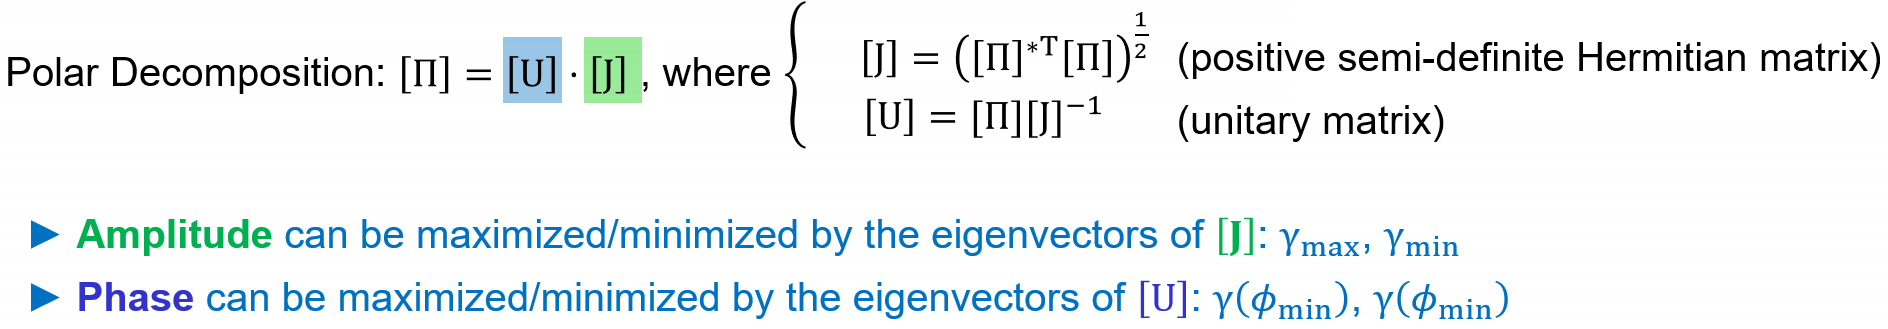
</div>

In [ ]:
# --- Optimized coherences in terms of phase and amplitude

**Step 8: Visualize the Coherence Region + computed coherences**

In [ ]:
# --- Plot coherence region for one pixel + calculated coherences

**Step 9: Plots !**

In [ ]:
# --- Open lidar height
H = rrat(path + 'Lida_r1503.rat', block=[minaz, maxaz, minrg, maxrg])

# --- Open vertical wavenumber
kz = rrat(path + 'kz_2d_demc_15tmpsar0302_15tmpsar0303_t01.rat', block=[minaz, maxaz, minrg, maxrg])

In [ ]:
# --- Plot height + phase differences

In [ ]:
# --- Plot height + coherences